In [150]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from hmmlearn.hmm import GaussianHMM, MultinomialHMM
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier



In [151]:
os.chdir('C:\\Users\\grace\\UNSW\\COMP4121\\COMP4121_MajorProject\\Data')

In [152]:
#Load datasets
raw_sales_df = pd.read_csv('raw_sales.csv', parse_dates=['datesold'])
ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])

C:\Users\grace\AppData\Local\Temp\ipykernel_17544\3741783504.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])


In [153]:
#Original data frames preview
print(raw_sales_df.head(5))
print(ma_lga_df.head(5))

    datesold  postcode   price propertyType  bedrooms
0 2007-02-07      2607  525000        house         4
1 2007-02-27      2906  290000        house         3
2 2007-03-07      2905  328000        house         3
3 2007-03-09      2905  380000        house         4
4 2007-03-21      2906  310000        house         3
    saledate      MA   type  bedrooms
0 2007-09-30  441854  house         2
1 2007-12-31  441854  house         2
2 2008-03-31  441854  house         2
3 2008-06-30  441854  house         2
4 2008-09-30  451583  house         2


In [154]:
# Step 1: Add year_quarter column to raw_sales_df and convert datesold to datetime
raw_sales_df['datesold'] = pd.to_datetime(raw_sales_df['datesold'])
raw_sales_df['year_quarter'] = raw_sales_df['datesold'].dt.year.astype(str) + '_Q' + raw_sales_df['datesold'].dt.quarter.astype(str)

# Step 2: Add year_quarter column to ma_lga_df and convert saledate to datetime
ma_lga_df['saledate'] = pd.to_datetime(ma_lga_df['saledate'])
ma_lga_df['year_quarter'] = ma_lga_df['saledate'].dt.year.astype(str) + '_Q' + ma_lga_df['saledate'].dt.quarter.astype(str)

In [155]:
# Step 3: Merge the dataframes on 'year_quarter', 'bedrooms', and 'type'
merged_df = pd.merge(
    raw_sales_df, 
    ma_lga_df[['year_quarter', 'type', 'bedrooms', 'MA']],  # Only the necessary columns from ma_lga_df
    how='left',  # Perform a left join to keep all rows from raw_sales_df
    left_on=['year_quarter', 'propertyType', 'bedrooms'],  # Merging keys
    right_on=['year_quarter', 'type', 'bedrooms']  # Merging keys in ma_lga_df
)

# Step 4: Rename columns to match raw_sales_df column names
merged_df = merged_df.rename(columns={
    'propertyType': 'property_type',  # Rename 'propertyType' to 'property_type'
    'datesold': 'date_sold'          # Rename 'datesold' to 'date_sold         # Fix duplicate column issue after merge
})

# Step 5: Drop 'property_type' column (duplicate after renaming)
merged_df['MA'] = merged_df['MA'].apply(lambda x: '{:.0f}'.format(x))
merged_df = merged_df.drop(columns=['type'])

# Step 6: Drop data entries with bedrooms = 0, since there are only 30 entries
merged_df = merged_df[merged_df['bedrooms'] != 0]

Feature Engineering
- Mutated 'normalized_price'
    - Based on median price in a given year_sold x and bedroom y
        - 'normalized_price_median' = 'price' / 'median_price' 

Background
- Let the median price-based normalized price represent the price relative to the specific bedroom category and year.
- Let the MA-based normalized price represent the long-term market trend.

- A 'normalized_price' close to 1 represents a given property is close to a median or stable market price, greater than 1.2 represents price is 20% higher , etc.




In [156]:
#Step 1: Mutate 'year_sold'
merged_df['year_sold'] = merged_df['date_sold'].dt.year
merged_df['month'] = merged_df['date_sold'].dt.month

# Step 2: Group by year and number of bedrooms to calculate median price
median_price_by_bedrooms_year = merged_df.groupby(['year_sold', 'bedrooms'])['price'].median().reset_index()
median_price_by_bedrooms_year.columns = ['year_sold', 'bedrooms', 'median_price']

# Step 3: convert 'median_price' and 'MA' to required float or int types
median_price_by_bedrooms_year['median_price'] = median_price_by_bedrooms_year['median_price'].astype('int64')
merged_df['MA'] = pd.to_numeric(merged_df['MA'], errors='coerce')

# Step 4: Merge 'merged_df' with 'median_price_by_bedrooms_year' on 'year_sold' and 'bedrooms'
merged_df = pd.merge(merged_df, median_price_by_bedrooms_year, on=['year_sold', 'bedrooms'], how='left')


In [157]:
# Step 1: Normalize price using MA and median price (as before)
merged_df['normalized_price'] = merged_df['price'] / merged_df['median_price']

print(merged_df.head(5))

   date_sold  postcode   price property_type  bedrooms year_quarter        MA  \
0 2007-02-07      2607  525000         house         4      2007_Q1  548969.0   
1 2007-02-27      2906  290000         house         3      2007_Q1  421291.0   
2 2007-03-07      2905  328000         house         3      2007_Q1  421291.0   
3 2007-03-09      2905  380000         house         4      2007_Q1  548969.0   
4 2007-03-21      2906  310000         house         3      2007_Q1  421291.0   

   year_sold  month  median_price  normalized_price  
0       2007      2        558000          0.940860  
1       2007      2        425000          0.682353  
2       2007      3        425000          0.771765  
3       2007      3        558000          0.681004  
4       2007      3        425000          0.729412  


In [158]:
merged_df_prescaling = merged_df[['date_sold', 'year_sold', 'price', 'bedrooms', 'year_quarter', 'MA', 'normalized_price']].dropna()
merged_df = merged_df[['date_sold', 'postcode', 'price', 'property_type', 'bedrooms', 'year_quarter', 'MA', 'normalized_price']].dropna()

#Save merged_df_prescaling
merged_df_prescaling.to_csv('merged_df_prescaling.csv', index=False)  # index=False to exclude row numbers
print("DataFrame saved as 'merged_df_prescaling.csv'")

DataFrame saved as 'merged_df_prescaling.csv'


Feature Engineering

- 'price_change'
- 'price_movement'
    - 0: Increasing
    - 1: Decreasing
    - 2: Stable

In [159]:
# Sort by 'year_quarter' to calculate price change over time
merged_df = merged_df.sort_values(by=['year_quarter'])

# Calculate price change percentage by quarter
merged_df['price_change'] = round(merged_df.groupby('year_quarter')['price'].pct_change() * 100, 2)  # price_change in %

threshold = 1  # Define a threshold percentage (e.g., 1% increase or decrease)
merged_df['price_movement'] = merged_df['price_change'].apply(
    lambda x: 1 if x > threshold else (0 if x < -threshold else np.nan)
)
merged_df = merged_df.dropna(subset=['price_movement'])
#y = merged_df['price_movement_binary']

'''# Define thresholds for movement classification (increase, stable, decrease)
threshold = 1  # Define a threshold percentage (e.g., 1% increase or decrease)
merged_df['price_movement'] = merged_df['price_change'].apply(
    lambda x: 0 if x < -threshold else (1 if abs(x) <= threshold else 2)
)

# Add a column for year for convenience if needed
merged_df['year'] = merged_df['date_sold'].dt.year
merged_df = merged_df[['MA', 'postcode', 'bedrooms','date_sold', 'price', 'property_type', 'normalized_price', 'year_quarter', 'price_change', 'price_movement']].dropna()

merged_df.head(10)'''

"# Define thresholds for movement classification (increase, stable, decrease)\nthreshold = 1  # Define a threshold percentage (e.g., 1% increase or decrease)\nmerged_df['price_movement'] = merged_df['price_change'].apply(\n    lambda x: 0 if x < -threshold else (1 if abs(x) <= threshold else 2)\n)\n\n# Add a column for year for convenience if needed\nmerged_df['year'] = merged_df['date_sold'].dt.year\nmerged_df = merged_df[['MA', 'postcode', 'bedrooms','date_sold', 'price', 'property_type', 'normalized_price', 'year_quarter', 'price_change', 'price_movement']].dropna()\n\nmerged_df.head(10)"

In [160]:
# Convert categorical variable 'propertyType' to numerical if needed
merged_df['year_quarter'] = merged_df['year_quarter'].astype('category').cat.codes  # Encode 'propertyType' as numeric
merged_df['normalized_price'] = merged_df['normalized_price'].astype('category').cat.codes
merged_df['property_type'] = merged_df['property_type'].astype('category').cat.codes
merged_df['postcode'] = merged_df['postcode'].astype('category').cat.codes
merged_df['price_movement'] = merged_df['price_movement'].astype('category').cat.codes

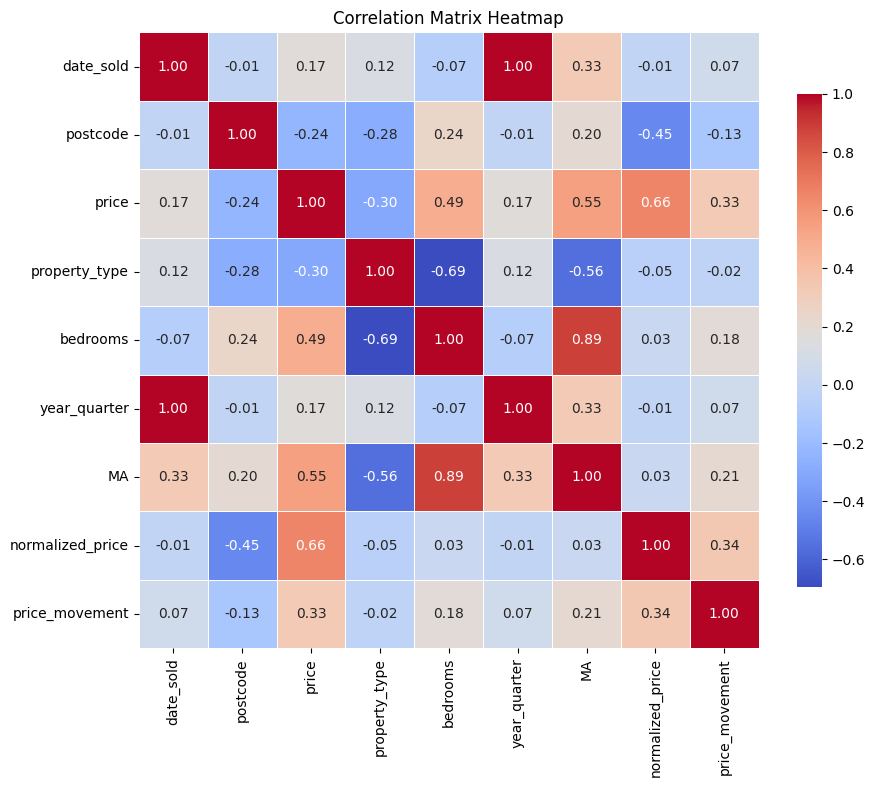

In [161]:
corr_matrix = merged_df[['date_sold', 'postcode', 'price', 'property_type', 'bedrooms', 'year_quarter', 'MA', 'normalized_price', 'price_movement']].corr()

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create the heatmap with annotations and a color map (e.g., 'coolwarm')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': .8})

# Add a title
plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()

In [162]:
# Define your features (X) and target (y)
X = merged_df[['normalized_price', 'MA', 'bedrooms']]  # Add any other relevant features
y = merged_df['price_movement']

# Split the data into training and test sets (e.g., 80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()

#X_train[['MA', 'bedrooms', 'normalized_price']] = scaler.fit_transform(X_train[['MA', 'bedrooms', 'normalized_price']])
#X_test[['MA', 'bedrooms', 'normalized_price']] = scaler.fit_transform(X_test[['MA', 'bedrooms', 'normalized_price']])
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train
y

1        0
2        1
3        1
4        0
13       1
        ..
24414    0
24415    1
24416    1
24418    1
29549    1
Name: price_movement, Length: 27502, dtype: int8

3. Determine Optimal Number of Hidden States:
- Train HMM for multiple n states
- Evaluate Log-likelihood
- Use AIC/BIC for Model Selection


I am modeling categorical states (price movement), so I will be using MultinomialHMM

In [163]:
#Step 3: Determine Optimal Number of Hidden States

# Discretize features into 10 bins (adjust bins as needed)
#discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=None)
#X_train_discretized = discretizer.fit_transform(X_train)

# Example: Iterate over different n states to find the optimal number
def find_optimal_states(features, max_states):
    aic_scores = []
    bic_scores = []
    models = []
    
    for n_states in range(2, max_states + 1):  # Test models with 2 to max_states
        hmm = GaussianHMM(n_components=n_states, random_state=42, n_iter=100)
        hmm.fit(features)
        models.append(hmm)
        
        # Calculate log likelihood
        log_likelihood = hmm.score(features)
        num_params = n_states**2 + 2 * n_states * features.shape[1] - 1 # Number of parameters
        
        # Calculate AIC and BIC
        aic = 2 * num_params - 2 * log_likelihood
        bic = np.log(len(features)) * num_params - 2 * log_likelihood
        
        aic_scores.append(aic)
        bic_scores.append(bic)
    
    # Find optimal number of states
    optimal_states_aic = 2 + np.argmin(aic_scores)
    optimal_states_bic = 2 + np.argmin(bic_scores)
    
    return optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models

#optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models = find_optimal_states(features=X_train_discretized, max_states=10)
optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models = find_optimal_states(features=X_train, max_states=10)

print(f"Optimal number of states based on AIC: {optimal_states_aic}")
print(f"Optimal number of states based on BIC: {optimal_states_bic}")

Optimal number of states based on AIC: 5
Optimal number of states based on BIC: 5


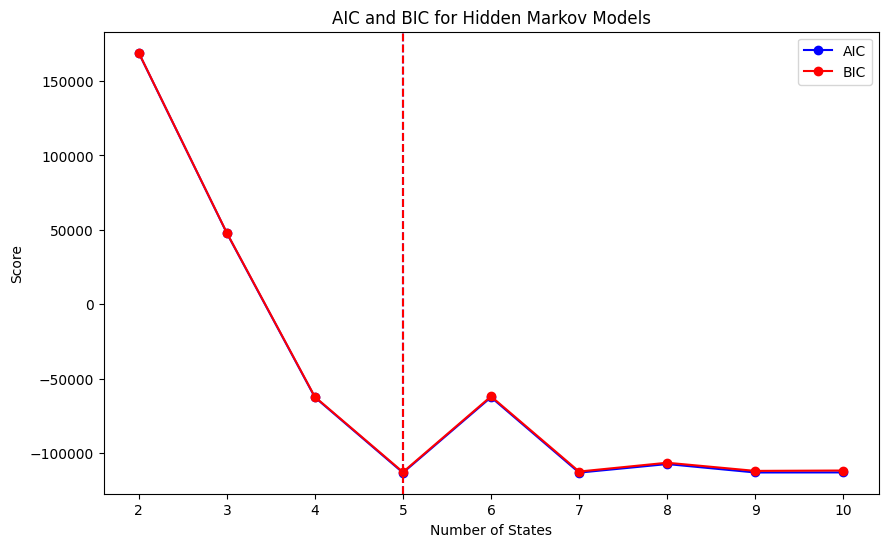

In [164]:
# Plot AIC and BIC
states_range = range(2, len(aic_scores) + 2)

plt.figure(figsize=(10, 6))
plt.plot(states_range, aic_scores, marker='o', label='AIC', color='blue')
plt.plot(states_range, bic_scores, marker='o', label='BIC', color='red')
plt.axvline(optimal_states_aic, color='blue', linestyle='--')
plt.axvline(optimal_states_bic, color='red', linestyle='--')
#plt.axvline(optimal_states_aic, color='blue', linestyle='--', label=f'Optimal States (AIC): {optimal_states_aic}')
#plt.axvline(optimal_states_bic, color='red', linestyle='--', label=f'Optimal States (BIC): {optimal_states_bic}')
plt.xlabel('Number of States')
plt.ylabel('Score')
plt.title('AIC and BIC for Hidden Markov Models')
plt.legend()
plt.show()

4. Train HMM with Optimal n States

- We found optimal n = 5

In [165]:
# Step 4: Train HMM on aggregated data

optimal_n = 5
hmm_model = GaussianHMM(n_components=optimal_n, n_iter=1000, random_state=42)  # 3 states: Decrease, Stable, Increase
#hmm_model.fit(X_train_discretized)
hmm_model.fit(X_train)

GaussianHMM(n_components=5, n_iter=1000, random_state=42)

5. Predict Hidden States for Partitioning

In [166]:
# Predict the hidden states
#hidden_states = hmm_model.predict(X_train_discretized)
hidden_states = hmm_model.predict(X_train)

# Create DataFrame with discretized features and hidden states
#X_train_df = pd.DataFrame(X_train_discretized, columns=['normalized_price', 'MA', 'bedrooms'])
X_train_df = pd.DataFrame(X_train, columns=['normalized_price', 'MA', 'bedrooms'])
X_train_df['hidden_state'] = hidden_states

6. Incorporate Hidden States into Classification
- Models:
    - Random Forest Classifier
    

In [167]:
#Train Random Forest Classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_train)

RandomForestClassifier(random_state=42)

In [168]:
# Predict hidden states on test data
#discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
#X_test_discretized = discretizer.fit_transform(X_test)

X_test_df = pd.DataFrame(X_test, columns=['normalized_price', 'MA', 'bedrooms'])
#X_test_df = pd.DataFrame(X_test_discretized, columns=['normalized_price', 'MA', 'bedrooms'])

hidden_states_test = hmm_model.predict(X_test_df)
X_test_df['hidden_state'] = hidden_states_test

# Predict the price movement using the classifier
predictions = classifier.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# Evaluate performance (accuracy, precision, recall, etc.)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.67      0.68      0.67      2626
           1       0.70      0.69      0.69      2875

    accuracy                           0.68      5501
   macro avg       0.68      0.68      0.68      5501
weighted avg       0.68      0.68      0.68      5501



In [192]:
# Discretize the features for the test set
from sklearn.preprocessing import KBinsDiscretizer
#discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
#X_test_discretized = discretizer.fit_transform(X_test)

X_test_df = pd.DataFrame(X_test, columns=['normalized_price', 'MA', 'bedrooms'])

# Predict hidden states using the HMM model
hidden_states_test = hmm_model.predict(X_test_df)
X_test_df['hidden_state'] = hidden_states_test

# --- 1. Logistic Regression ---
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
logreg_predictions = logreg.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 2. Support Vector Machine (SVM) ---
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
svm_predictions = svm.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 3. K-Nearest Neighbors (KNN) ---
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
knn_predictions = knn.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 4. Decision Tree ---
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
dtree_predictions = dtree.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 5. Gradient Boosting ---
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
gbc_predictions = gbc.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- Evaluate Performance of Each Model ---
from sklearn.metrics import classification_report

# Logistic Regression Evaluation
#print("Logistic Regression Performance:")
#print(classification_report(y_test, logreg_predictions))

# Support Vector Machine Evaluation
#print("Support Vector Machine Performance:")
#print(classification_report(y_test, svm_predictions))

# K-Nearest Neighbors Evaluation
print("K-Nearest Neighbors Performance:")
print(classification_report(y_test, knn_predictions))

# Decision Tree Evaluation
print("Decision Tree Performance:")
print(classification_report(y_test, dtree_predictions))

# Gradient Boosting Evaluation
print("Gradient Boosting Performance:")
print(classification_report(y_test, gbc_predictions))


K-Nearest Neighbors Performance:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2626
           1       0.78      0.80      0.79      2875

    accuracy                           0.78      5501
   macro avg       0.78      0.78      0.78      5501
weighted avg       0.78      0.78      0.78      5501

Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2626
           1       0.99      0.96      0.97      2875

    accuracy                           0.97      5501
   macro avg       0.97      0.97      0.97      5501
weighted avg       0.97      0.97      0.97      5501

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      2626
           1       0.72      0.78      0.75      2875

    accuracy                           0.73      5501
   macro avg       0.73      0.73    

In [180]:
# --- 1. Logistic Regression ---
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_test_df[['normalized_price', 'MA', 'bedrooms']], y_test)
baseline_predictions = logreg.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])
# Predict on the test data


#baseline_predictions = classifier.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])


In [181]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
X_test_df2 = X_test_df.copy()
logreg.fit(X_test_df2[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
predictions_with_hmm = logreg.predict(X_test_df2[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

In [182]:
from sklearn.metrics import classification_report

print("Model without Hidden States:")
print(classification_report(y_test, baseline_predictions))

print("Model with Hidden States:")
print(classification_report(y_test, predictions_with_hmm))


Model without Hidden States:
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      2626
           1       0.69      0.67      0.68      2875

    accuracy                           0.67      5501
   macro avg       0.67      0.67      0.67      5501
weighted avg       0.67      0.67      0.67      5501

Model with Hidden States:
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      2626
           1       0.69      0.67      0.68      2875

    accuracy                           0.67      5501
   macro avg       0.67      0.67      0.67      5501
weighted avg       0.67      0.67      0.67      5501



In [185]:
# --- 3. K-Nearest Neighbors (KNN) ---
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
knn_predictions = knn.predict(X_test_df[['normalized_price', 'MA', 'bedrooms','hidden_state']])

# --- 4. Decision Tree ---
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_test_df[['normalized_price', 'MA','bedrooms', 'hidden_state']], y_test)
dtree_predictions = dtree.predict(X_test_df[['normalized_price', 'MA','bedrooms', 'hidden_state']])

# --- 5. Gradient Boosting ---
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_test_df[['normalized_price', 'MA', 'bedrooms','hidden_state']], y_test)
gbc_predictions = gbc.predict(X_test_df[['normalized_price', 'MA', 'bedrooms','hidden_state']])



Model without Hidden States:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2626
           1       0.78      0.80      0.79      2875

    accuracy                           0.78      5501
   macro avg       0.78      0.78      0.78      5501
weighted avg       0.78      0.78      0.78      5501

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2626
           1       0.99      0.96      0.97      2875

    accuracy                           0.97      5501
   macro avg       0.97      0.97      0.97      5501
weighted avg       0.97      0.97      0.97      5501

              precision    recall  f1-score   support

           0       0.74      0.67      0.70      2626
           1       0.72      0.78      0.75      2875

    accuracy                           0.73      5501
   macro avg       0.73      0.73      0.73      5501
weighted avg       0.73      0.73      0.73  

In [187]:
# --- 3. K-Nearest Neighbors (KNN) ---
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_test_df[['normalized_price', 'MA', 'bedrooms']], y_test)
baseline_knn_predictions = knn.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])

# --- 4. Decision Tree ---
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_test_df[['normalized_price', 'MA', 'bedrooms']], y_test)
baseline_dtree_predictions = dtree.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])

# --- 5. Gradient Boosting ---
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_test_df[['normalized_price', 'MA', 'bedrooms']], y_test)
baseline_gbc_predictions = gbc.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])


In [188]:

print("Model without Hidden States:")
print(classification_report(y_test, baseline_knn_predictions))
print(classification_report(y_test, baseline_dtree_predictions))
print(classification_report(y_test, baseline_gbc_predictions))






Model without Hidden States:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      2626
           1       0.78      0.80      0.79      2875

    accuracy                           0.78      5501
   macro avg       0.78      0.78      0.78      5501
weighted avg       0.78      0.78      0.78      5501

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2626
           1       0.99      0.96      0.97      2875

    accuracy                           0.97      5501
   macro avg       0.97      0.97      0.97      5501
weighted avg       0.97      0.97      0.97      5501

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      2626
           1       0.73      0.78      0.75      2875

    accuracy                           0.73      5501
   macro avg       0.73      0.73      0.73      5501
weighted avg       0.73      0.73      0.73  

In [189]:
print("Model with Hidden States:")
print(classification_report(y_test, knn_predictions))
print(classification_report(y_test, dtree_predictions))
print(classification_report(y_test, gbc_predictions))

Model with Hidden States:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2626
           1       0.78      0.80      0.79      2875

    accuracy                           0.78      5501
   macro avg       0.78      0.78      0.78      5501
weighted avg       0.78      0.78      0.78      5501

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2626
           1       0.99      0.96      0.97      2875

    accuracy                           0.97      5501
   macro avg       0.97      0.97      0.97      5501
weighted avg       0.97      0.97      0.97      5501

              precision    recall  f1-score   support

           0       0.74      0.67      0.70      2626
           1       0.72      0.78      0.75      2875

    accuracy                           0.73      5501
   macro avg       0.73      0.73      0.73      5501
weighted avg       0.73      0.73      0.73     

In [176]:
print("Model without Hidden States:")
print(classification_report(y_test, baseline_dtree_predictions))

print("Model with Hidden States:")
print(classification_report(y_test, dtree_predictions))



Model without Hidden States:
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      2626
           1       0.70      0.70      0.70      2875

    accuracy                           0.69      5501
   macro avg       0.69      0.69      0.69      5501
weighted avg       0.69      0.69      0.69      5501

Model with Hidden States:
              precision    recall  f1-score   support

           0       0.68      0.65      0.67      2626
           1       0.69      0.72      0.71      2875

    accuracy                           0.69      5501
   macro avg       0.69      0.69      0.69      5501
weighted avg       0.69      0.69      0.69      5501



In [177]:
print("Model without Hidden States:")
print(classification_report(y_test, baseline_knn_predictions))

print("Model with Hidden States:")
print(classification_report(y_test, knn_predictions))

Model without Hidden States:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      2626
           1       0.66      0.67      0.67      2875

    accuracy                           0.65      5501
   macro avg       0.65      0.65      0.65      5501
weighted avg       0.65      0.65      0.65      5501

Model with Hidden States:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66      2626
           1       0.69      0.65      0.67      2875

    accuracy                           0.66      5501
   macro avg       0.66      0.67      0.66      5501
weighted avg       0.67      0.66      0.66      5501



ValueError: x and y must have same first dimension, but have shapes (27502,) and (22001,)

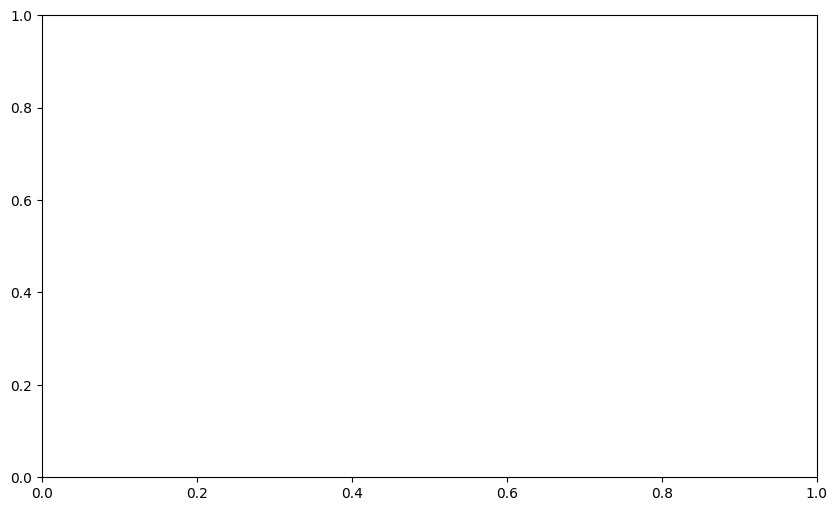

In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(merged_df['year_quarter'], hidden_states, label='Hidden States')
plt.xlabel('Time (Year-Quarter)')
plt.ylabel('Hidden States')
plt.title('State Transitions Over Time')
plt.legend()
plt.show()
